In [ ]:
!pip install tf-nightly --quiet
import glob
from google.colab import drive
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
# import timeit
# from sklearn.decomposition import PCA
# from sklearn.manifold import TSNE
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras import layers, models, Model
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from tensorflow import keras
from sklearn.metrics.pairwise import cosine_similarity


     |████████████████████████████████| 323.8MB 48kB/s 
     |████████████████████████████████| 460kB 44.0MB/s 
     |████████████████████████████████| 6.7MB 40.1MB/s 


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


2.4.0-dev20200802


In [ ]:
#Mounting the drive
drive.mount('/content/drive', force_remount=True)
#Unziping the dataset to current working director
!unzip -q "/content/drive/My Drive/Colab Notebooks/Shirt_Images.zip"
!unzip -q "/content/drive/My Drive/Colab Notebooks/Shoe_Images.zip"
!unzip -q "/content/drive/My Drive/Colab Notebooks/Watch_Images.zip"
#making "Dataset" folder in the current working directory
!mkdir Dataset
#Moving unzipped folders to Dataset folder
!mv Shirt_Images Dataset
!mv Shoe_Images Dataset
!mv Watch_Images Dataset


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Reading the dataset

In [ ]:
path = "Dataset/" 
image_size = 128
channels = 3
types = ["Shirt_Images", "Shoe_Images", "Watch_Images"]
# labels = []
# images = []

total_images = 0
for root, dirs, files in os.walk(path):
    total_images += len(files)
labels = np.empty(total_images)
images = np.empty((total_images,image_size,image_size,channels))
gray_images = np.empty((total_images,image_size,image_size))
heights = np.empty(total_images)
widths = np.empty(total_images) 
count = 0
for i in types:
    print("Reading the  data for: ", i)
    for p in os.listdir(path + i):
        image = cv2.imread(path + i + '/' + p)
        heights[count] = image.shape[0]
        widths[count] = image.shape[1]
        #height.append(image.shape[0])
        #width.append(image.shape[1])
        image = cv2.resize(image, (image_size, image_size))
        #images.append(image) 
        #labels.append(types.index(i))
        gray_images[count] = (cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))/255.2
        image = image/255.0
        images[count] = image
        labels[count] = types.index(i)
        
        count+=1

# print("\nNumber of Dataset {} and Number of Labels {}".format(len(images),len(labels))) 
# print("Single Image Shape:", dataset[0].shape)

Reading the  data for:  Shirt_Images
Reading the  data for:  Shoe_Images
Reading the  data for:  Watch_Images


## Train-Test Split

In [ ]:
# Split Dataset to train\test
trainX, testX, trainY, testY = train_test_split(images, labels, test_size=0.2, random_state=1)
print("X Train shape:", trainX.shape)
print("X Test shape:", testX.shape)
print("Y Train shape:", trainY.shape)
print("Y Test shape:", testY.shape)

X Train shape: (4838, 128, 128, 3)
X Test shape: (1210, 128, 128, 3)
Y Train shape: (4838,)
Y Test shape: (1210,)


## Feature Extraction

In [ ]:
numChannels = 3
numClasses = 3
model = models.Sequential()
inputShape = (image_size, image_size, numChannels)
model.add(layers.Conv2D(filters= 6, kernel_size= 5,activation="relu", input_shape= inputShape))
model.add(layers.MaxPooling2D(pool_size= (2, 2), strides= (2, 2)))
model.add(layers.Conv2D(filters= 16, kernel_size= 5,activation="relu"))
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(4096))
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 124, 124, 6)       456       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 62, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 58, 58, 16)        2416      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 29, 29, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 13456)             0         
_________________________________________________________________
dense (Dense)                (None, 4096)              55119872  
Total params: 55,122,744
Trainable params: 55,122,744
Non-trainable params: 0
____________________________________________

In [ ]:
model.save('lenet_features_extractor.h5')

In [ ]:
features = model.predict(trainX)
print(features.shape)

(4838, 4096)


In [ ]:
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=3, algorithm='ball_tree', metric='euclidean', n_jobs = -1).fit(features)

## Save sklearn model

In [ ]:
import joblib
filename = 'nbrs_model.sav'
joblib.dump(nbrs, filename)

['nbrs_model.sav']

In [ ]:
random_index = np.random.randint(0,len(testX))
single_image = testX[random_index]
single_image_features = model.predict(np.expand_dims(single_image,axis=0))
print(single_image_features.shape)
indeces = nbrs.kneighbors(single_image_features,3,return_distance=False)

(1, 4096)


In [ ]:
print(indeces.shape)

(1, 3)


In [ ]:
print(indeces)

[[2282 2719 3327]]


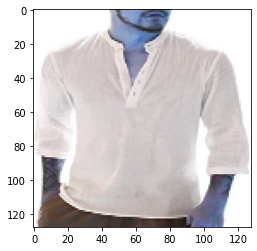

In [ ]:
plt.imshow(single_image)
plt.show()

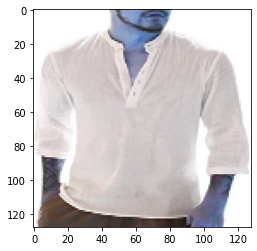

In [ ]:
plt.imshow(trainX[indeces[0,0]])

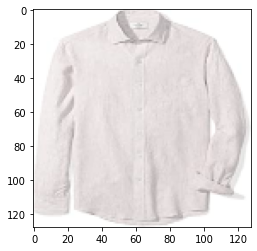

In [ ]:
plt.imshow(trainX[indeces[0,1]])

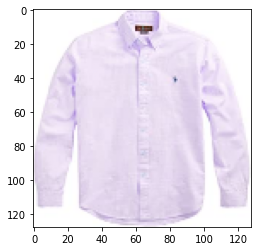

In [ ]:
plt.imshow(trainX[indeces[0,2]])